# Explore VAE on precipitation data

The notebook demonstrates the process of exploring a Variational Autoencoder (VAE) trained on precipitation data and exporting its predictions as netCDF files. The key steps and components involved are outlined as follows:

1. The configuration parameters of the model are loaded from the `LOG_DIR` folder.

2. The VAE model consists of four components: _encoder_, _latent sampling_, _decoder_, and a _second decoder for prediction_. Separate model instances are created for each component:
    * _Encoder_: The encoder takes a sample `x` and returns the mean `z_mean` and logarithmic variance `z_log_var` of the latent variable `z`.
    * _Latent Sampling_: The latent sampling takes `z_mean` and `z_log_var` as inputs and generates a random latent sample `z`.
    * _Decoder_: The decoder reconstructs the input `x` by taking the latent sample `z` and producing the decoded output `y`. The decoding is done backward in time, maintaining the input order.
   * _Decoder for Prediction_: The second decoder also takes the latent sample `z` but generates a forward-time prediction output.
   
3. The model weights from the training process are loaded from the `LOG_DIR` folder.
   
4. Observational data in netCDF format is loaded, with different variables stacked along the channel axis. The data is split into training and validation time intervals.

5. Properties of the `encoder` and `decoder` are analyzed. KL divergence of latent variables is analyzed to identify important dimensions. The temporal behavior of latent variables is also examined using the validation dataset.

6. The model outputs are obtained for the validation data. The outputs of the `decoder` and `prediction` are collected separately and aligned with the target month. The VAE output is restricted to specific time lags for reducing file size.

7. The model output is projected into grid space by calculating the scalar product of the output with EOFs (Empirical Orthogonal Functions). The corresponding climatological mean fields are loaded and added to obtain absolute values. The resulting grid-space reconstruction is exported as netCDF files in the specified `EXPORT_DIR` folder.

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
from types import SimpleNamespace

import numpy as np
import pandas as pd
import tensorflow.keras as ks
import yaml
from matplotlib import dates
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import signal

In [3]:
from tensorflow import get_logger
from tensorflow.compat.v1 import disable_eager_execution, disable_v2_behavior

get_logger().setLevel('ERROR')
disable_eager_execution()
disable_v2_behavior()

In [4]:
from VAE import generators, models
from VAE.utils import fileio
from VAE.utils import plot as vplt

In [5]:
FIGWIDTH = 16
VERBOSE = 1
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 75
np.set_printoptions(formatter={'float_kind': lambda x: f'{x: .3f}'}, linewidth=120)

## Parameters

We load the configuration from the the folder `LOG_DIR`. The model output is written to netCDF files in the folder given in `EXPORT_DIR`.

In [6]:
EPOCH = 100
LOG_DIR = r'logs/2023-06-16T15.59'
MODEL_FILE = f'model.{EPOCH:02d}.h5'
EXPORT_DIR = r'results/2023-06-16T15.59'

In [7]:
print('LOG_DIR    :', LOG_DIR)
print('MODEL_FILE :', MODEL_FILE)
print('EXPORT_DIR :', EXPORT_DIR)

LOG_DIR    : logs/2023-06-16T15.59
MODEL_FILE : model.100.h5
EXPORT_DIR : results/2023-06-16T15.59


First let's load the parameters from the model training in `trainer_config.yaml`.

In [8]:
fn = os.path.join(LOG_DIR, 'trainer_config.yaml')
with open(fn, 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

print('Load configuration from:', os.path.normpath(fn))

assert params['model'].get('__version__') == models.__version__, 'Model version mismatch.'
assert params['fit_generator'].get('__version__') == generators.__version__, 'Generator version mismatch.'

params = SimpleNamespace(**params)

Load configuration from: logs\2023-06-16T15.59\trainer_config.yaml


Make some modifications to the parameters. To change the number of model runs that are used to obtain the ensemble statistics exported as netCDF, we can change the parameter `repeat_samples`.

In [9]:
params.model['beta'] = 1.  # no beta scheduler needed at inference time
params.fit_generator2['shuffle'] = False  # do not shuffle samples
params.fit_generator2['ensemble_replace'] = True  # sample from ensemble index with replacement

params.fit_generator2['batch_size'] = 10  # reduce batch size if increasing number of repetitions
params.fit_generator2['repeat_samples'] = 32  # set number of repetitions = model runs

if EPOCH <= params.model_fit['epochs']:
    params.model2 = {}  # remove model params of TF learning if model weights of pre-trained model will be loaded

In [10]:
# print(yaml.dump(params.__dict__))

## Model

The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component.

### Encoder

The encoder takes a sample `x` and returns `z_mean` and `z_log_var`:

In [11]:
encoder = models.Encoder(**params.model, name='encoder')

### Latent sampling

The latent sampling takes the two inputs `z_mean` and `z_log_var` and returns a set of `set_size=1` random latent sample `z`:

In [12]:
latent_sampling = models.LatentSampling(**params.model, name='latent')

### Decoder

The decoder, finally, takes a latent sample `z` and returns the decoded output `y` to reconstruct `x`. The decoding works backward in time and we set `output_reverse=True` so that the order of decoder output matches the input to the encoder.

In [13]:
decoder = models.Decoder(output_shape=params.model.get('input_shape'),
                         decoder_blocks=params.model.get('encoder_blocks'),
                         output_reverse=True,
                         **params.model,
                         name='decoder')

### Decoder for prediction

Like the decoder, the second decoder takes the same latent sample `z` and it's output will provide the prediction. In contrast to the `decoder`, we set `output_reverse=False` so that the output of `prediction` is forward in time.

In [14]:
prediction = models.Decoder(output_shape=params.model.get('prediction_shape'),
                            output_reverse=False,
                            **{
                                'decoder_blocks': params.model.get('encoder_blocks'),
                                **params.model,
                                **params.prediction
                            },
                            name='prediction')

### Full model

Now that we have the four components, we a ready to create the full model.

In [15]:
model = models.VAEp(encoder, decoder, latent_sampling, prediction, **{**params.model, **params.model2})

Let's plot the model

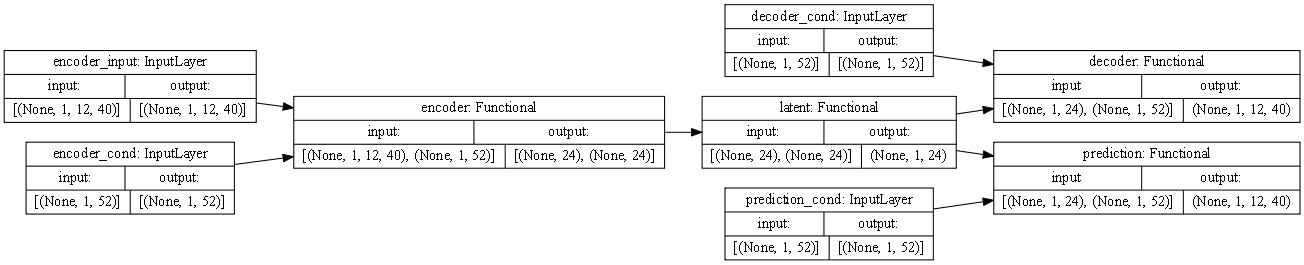

In [16]:
ks.utils.plot_model(model, show_shapes=True, dpi=75, rankdir='LR')

and summarizes the model

In [17]:
model.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 12, 40)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 52)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 24), (None, 24)]   187210        encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

### Load model weights

We load the model weights from the training.

In [18]:
fn = os.path.join(LOG_DIR, MODEL_FILE)
model.load_weights(fn, by_name=True)
print('Load model weights from:', os.path.normpath(fn))

Load model weights from: logs\2023-06-16T15.59\model.100.h5


## Data

We load the netCDF data representing the observational data.

In [19]:
_variables, _dimensions, _attributes = fileio.read_netcdf_multi(**params.data2, num2date=True)

data\gpcc\prj\pcs_anom_gpcc_v2020_1dgr.nc : 1 file(s) found.
data\ersst\prj\pcs_anom_ersstv5.nc        : 1 file(s) found.
2/2 [==============================] - 0s 115ms/file


We assume a single set of different variables for observational data.

In [20]:
variables = {
    k: pd.DataFrame(v, index=_dimensions[key]['time'])
    for key, value in _variables.items() for k, v in value.items()
}

dimensions = {k: _dimensions[key] for key, value in _variables.items() for k in value}
attributes = {k: _attributes[key] for key, value in _variables.items() for k in value}

variable_names = tuple(variables.keys())
variable_channels = tuple([v.shape[-1] for v in variables.values()])

print('Variables found :', variable_names)
print('Channel found   :', variable_channels)

Variables found : ('precip', 'sst')
Channel found   : (20, 20)


We stack the different variables along the last axis, the channel axis, and add a leading singleton dimension for `set_size=1`.

In [21]:
data_stack = pd.concat([variables[variable2_name] for variable2_name in variable_names], axis=1, join='inner')
time = data_stack.index
dataset = data_stack.to_numpy()[None, ...]

We split the observations into two time intervals, one for training and one for validation.

In [22]:
validation_split = np.searchsorted(time, np.datetime64(params.fit_generator2['validation_split']))
print(f"Training interval   : {time[:validation_split][[0, -1]]}")
print(f"Validation interval : {time[validation_split:][[0, -1]]}")

Training interval   : DatetimeIndex(['1891-01-01', '1980-08-01'], dtype='datetime64[ns]', freq=None)
Validation interval : DatetimeIndex(['1980-09-01', '2019-12-01'], dtype='datetime64[ns]', freq=None)


In the following plot, we show the observational data.

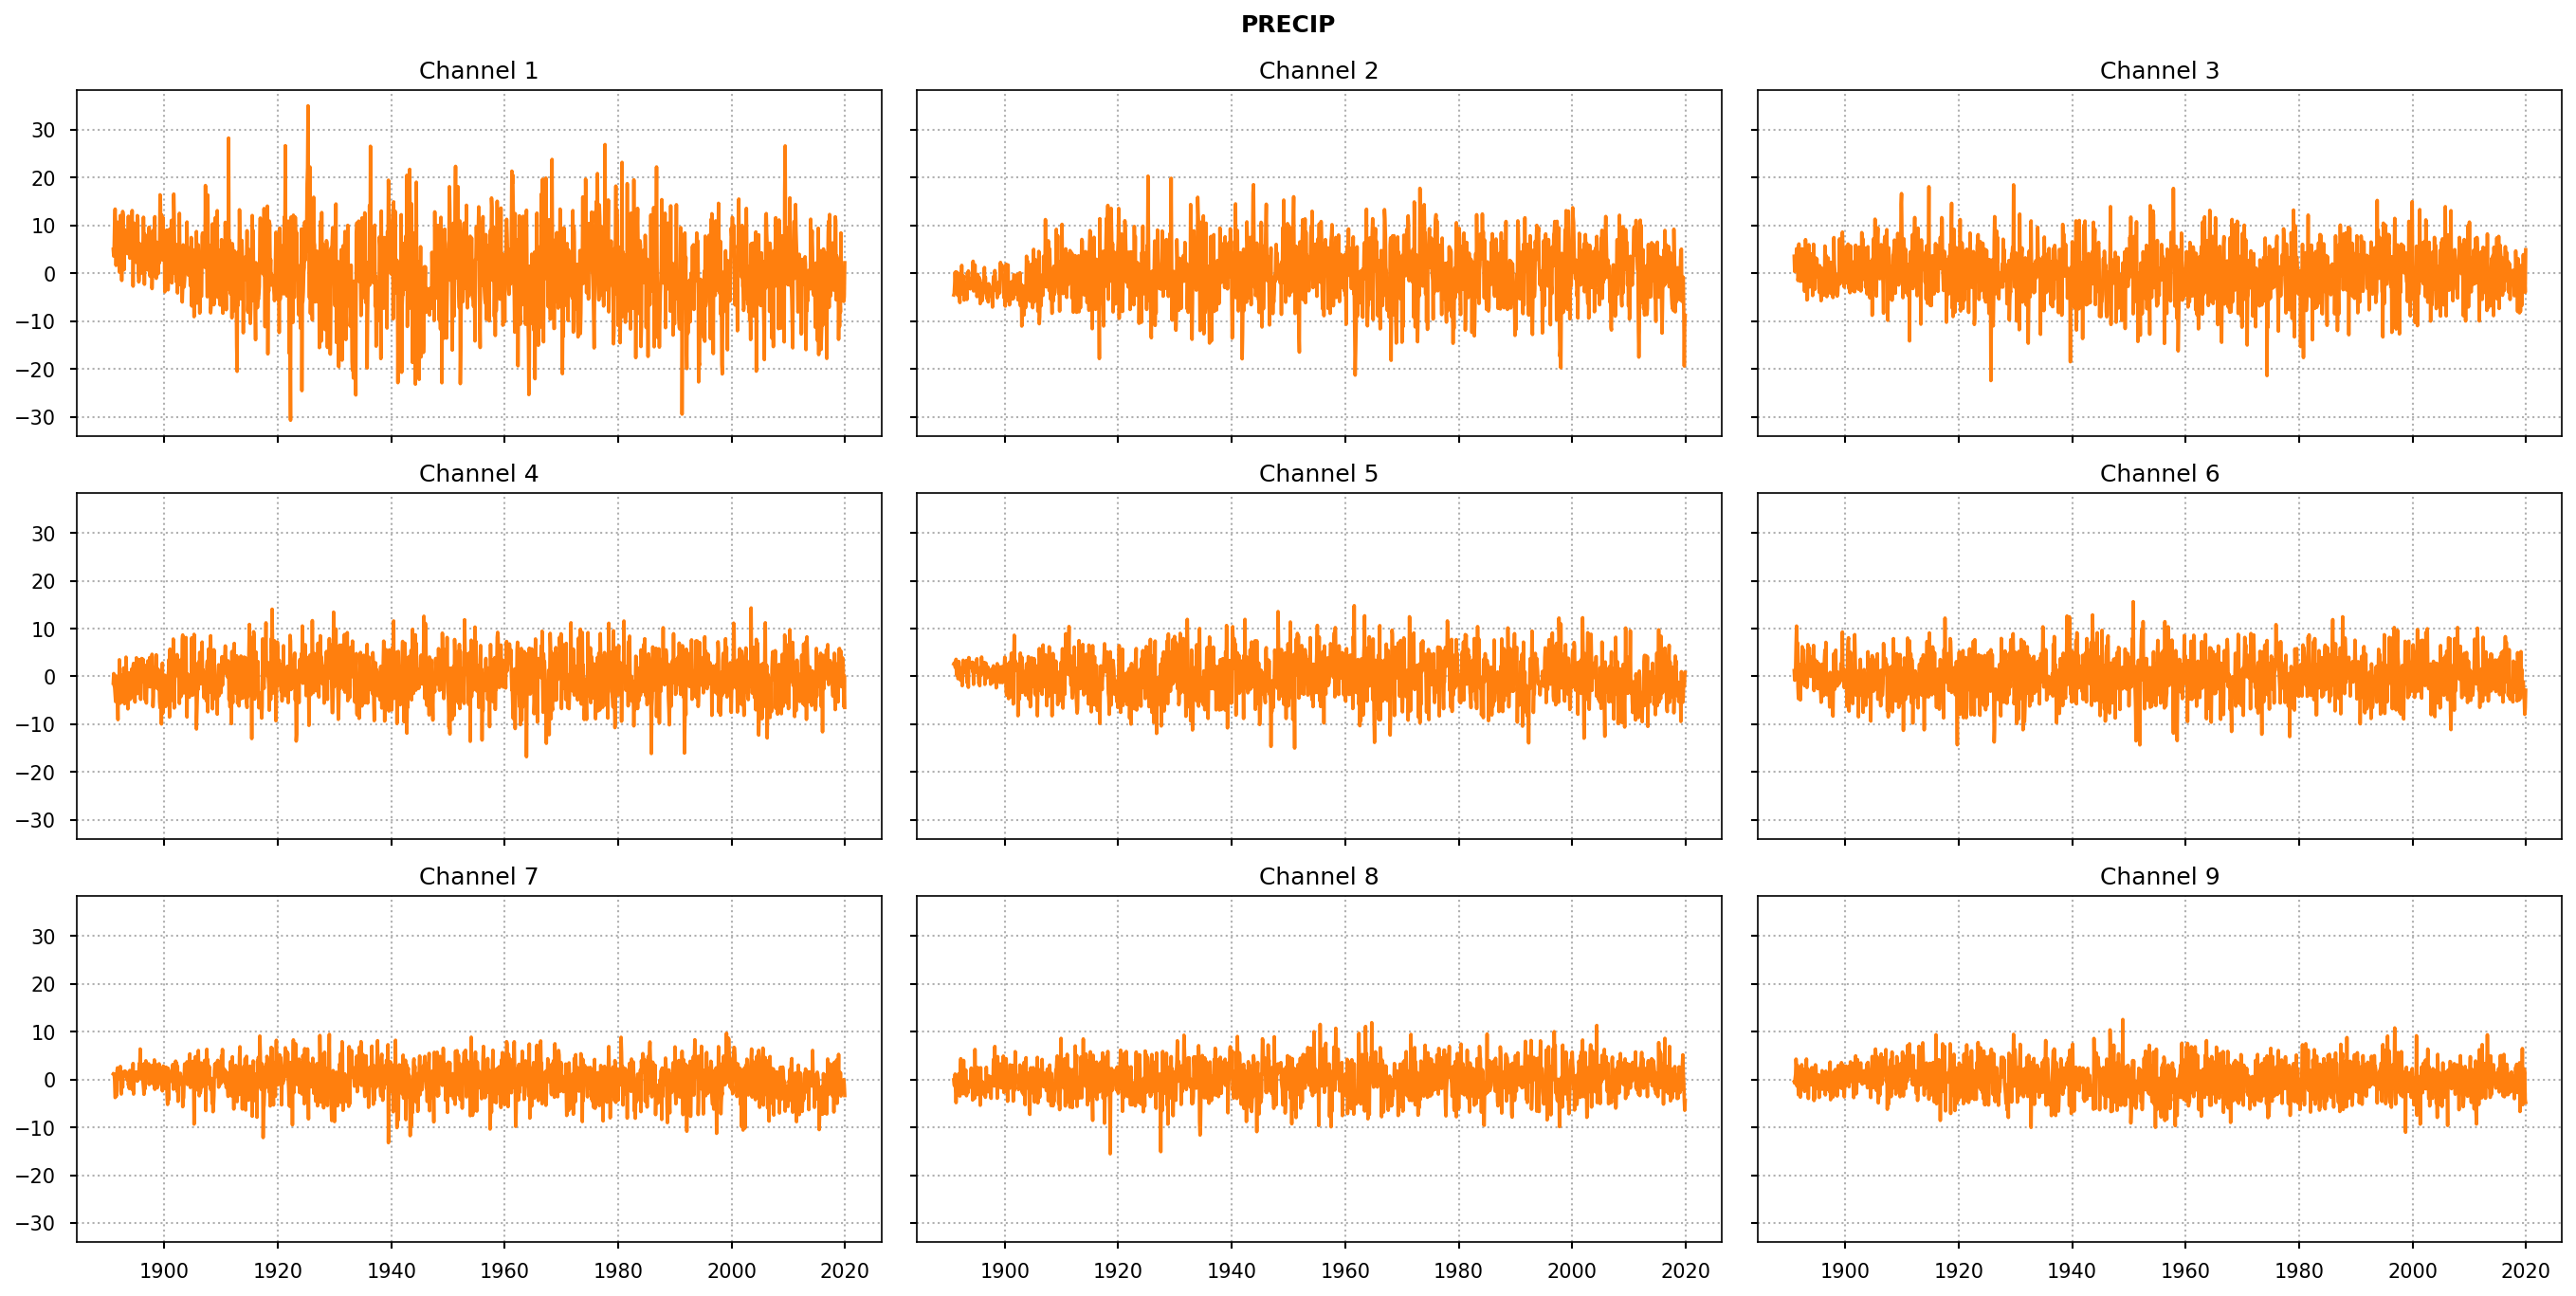

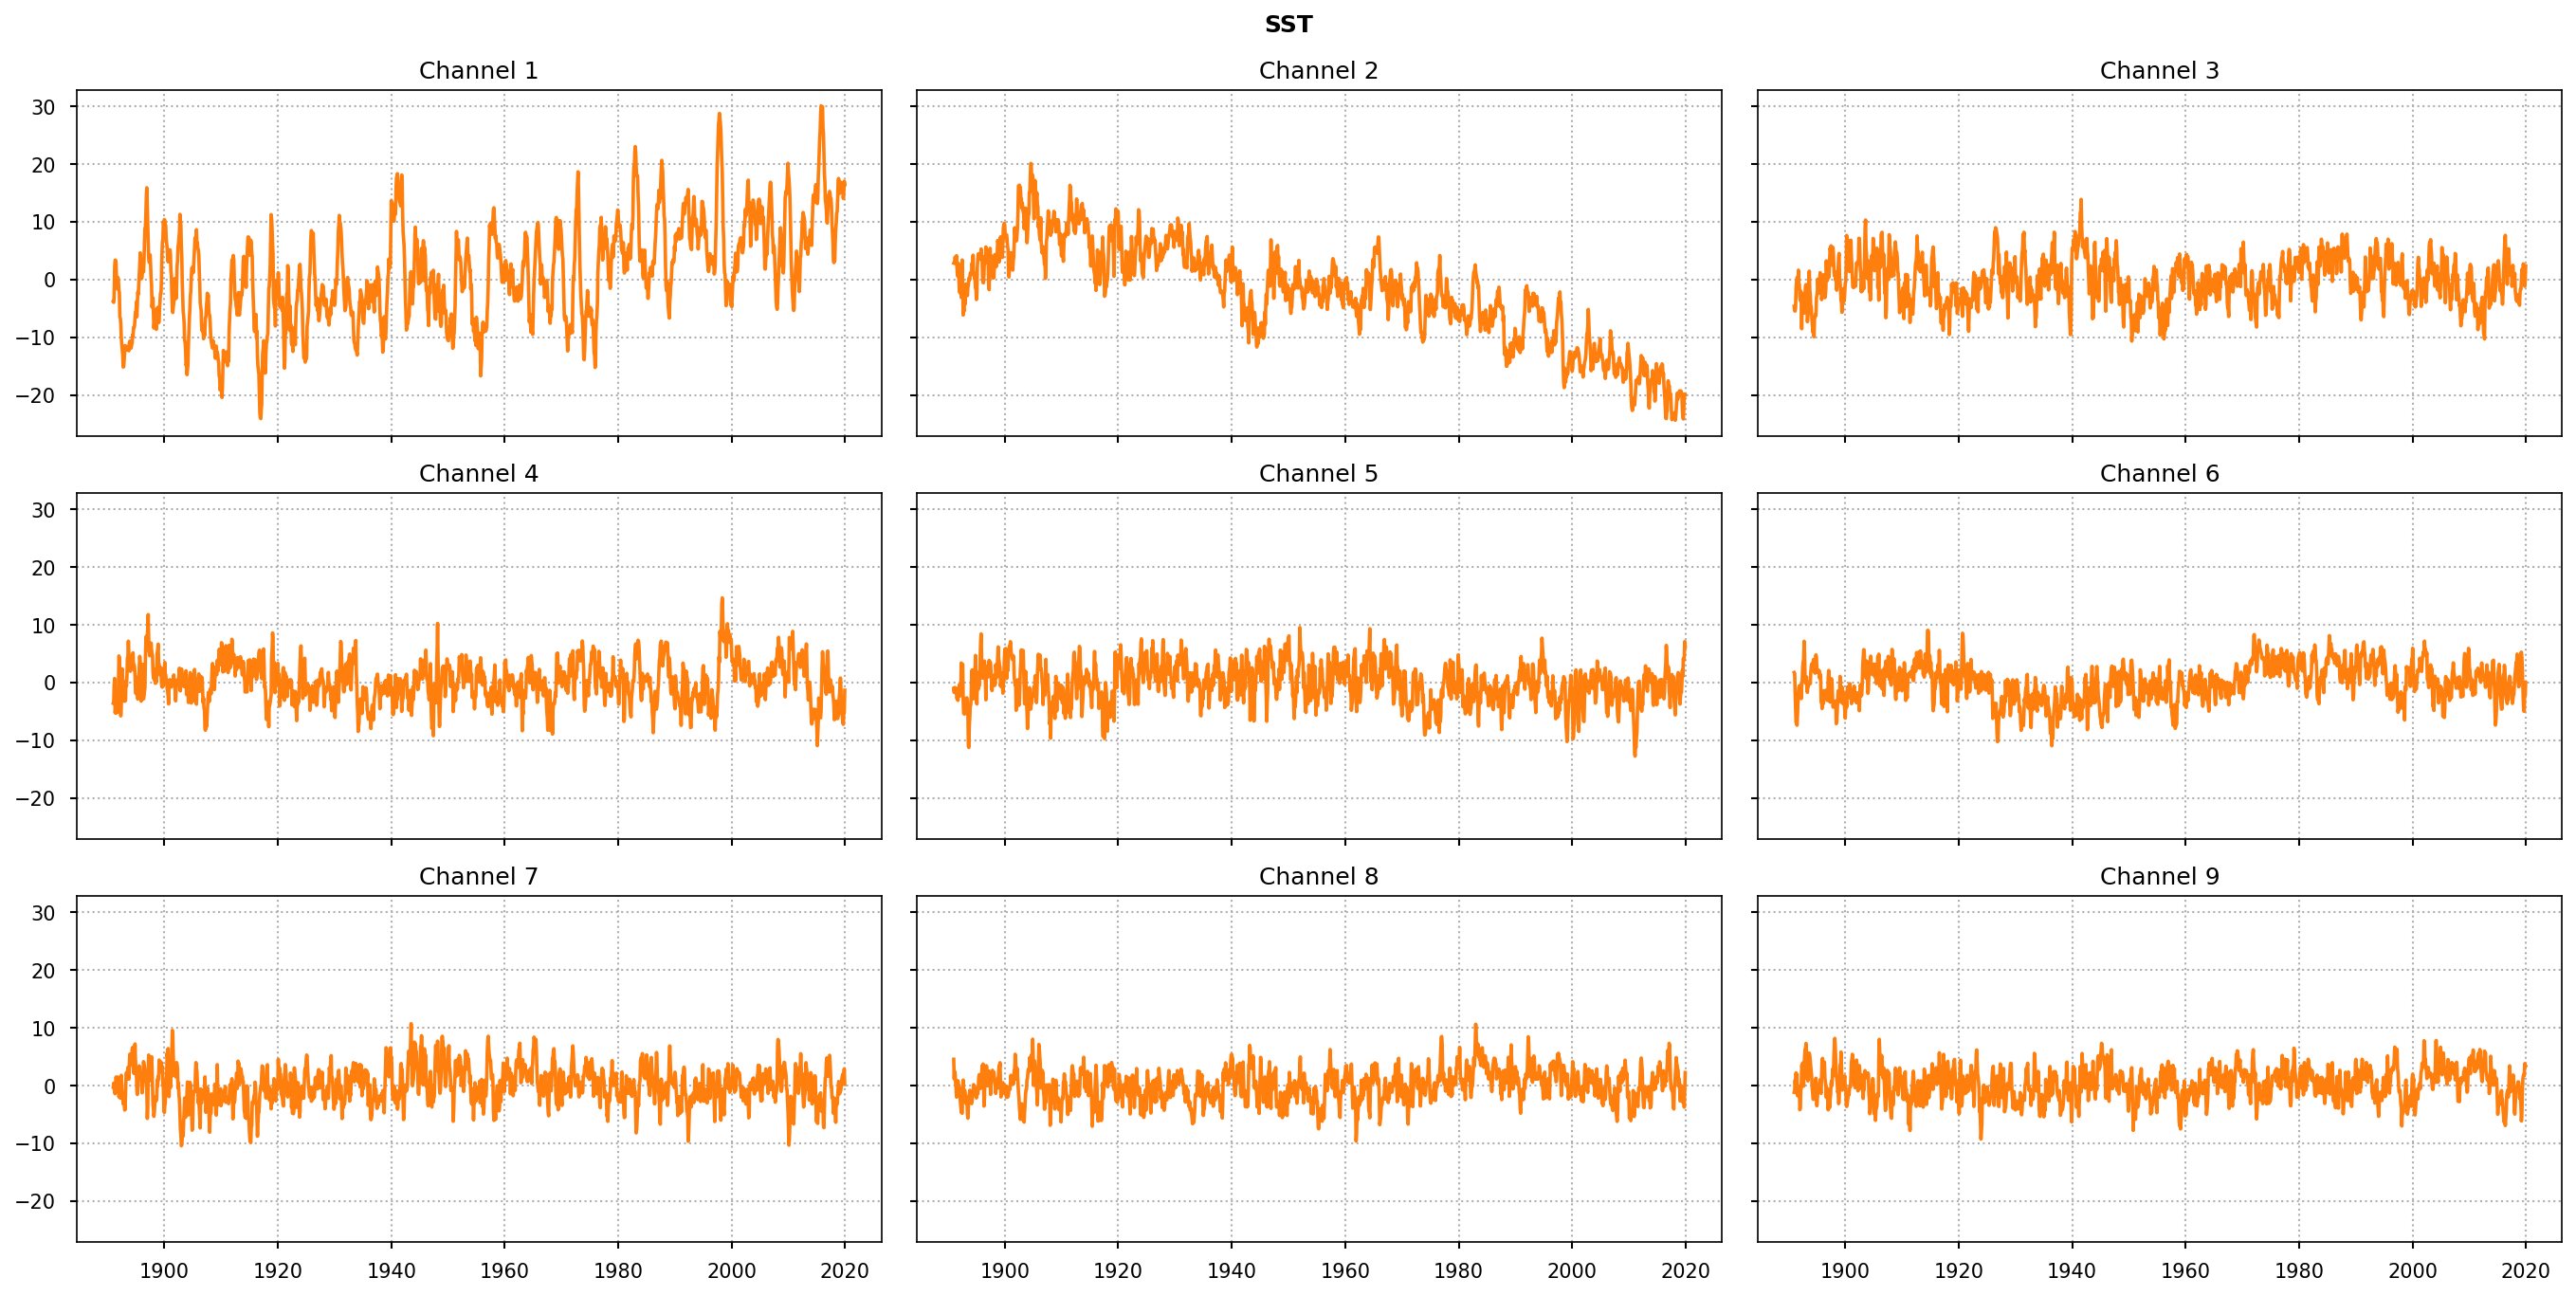

In [23]:
cols = 3
rows = 3

for variable_name in variable_names:
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(6 * cols, 3 * rows), squeeze=False)
    fig.suptitle(variable_name.upper(), fontweight='bold')

    for channel, (ax, value) in enumerate(zip(axs.flat, variables[variable_name].values.T), start=1):
        p2, = ax.plot(time, value, color='tab:orange', zorder=2.2)
        ax.grid(linestyle=':')
        ax.set_title(f'Channel {channel}')

## Prepare generator

The generator takes observational data after the validation split and is used to evaluate the transfer learning.

In [24]:
month = time.to_numpy().astype('datetime64[M]').astype(int)
val_gen = generators.FitGenerator(dataset[:, validation_split:, :],
                                  time=month[validation_split:],
                                  **{
                                      **params.fit_generator,
                                      **params.fit_generator2
                                  })
val_gen.summary()

Number of datasets : 1
Total data size    : 18,880
Total data length  : 472
Strides            : 1
Number of samples  : 449
Batch size         : 10
Number of batches  : 45
Sample repetitions : 32
Actual batch size  : 10 * 32 = 320
Shuffle            : False
Ensemble condition
  size : 40
  type : random
  range   : (0, 40)
  sync    : True
  replace : True
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (320, 1, 12, 40)
    encoder_cond     : (320, 1, 52)
    decoder_cond     : (320, 1, 52)
    prediction_cond  : (320, 1, 52)
  targets
    decoder          : (320, 1, 12, 40)
    prediction       : (320, 1, 12, 40)


## Latent space

The module `VAE.utils.plot` provides multiple functions to plot and analyze properties of the `encoder` and the `decoder`. First let's start with the `encoder` and explore properties of the latent space.

### KL divergence

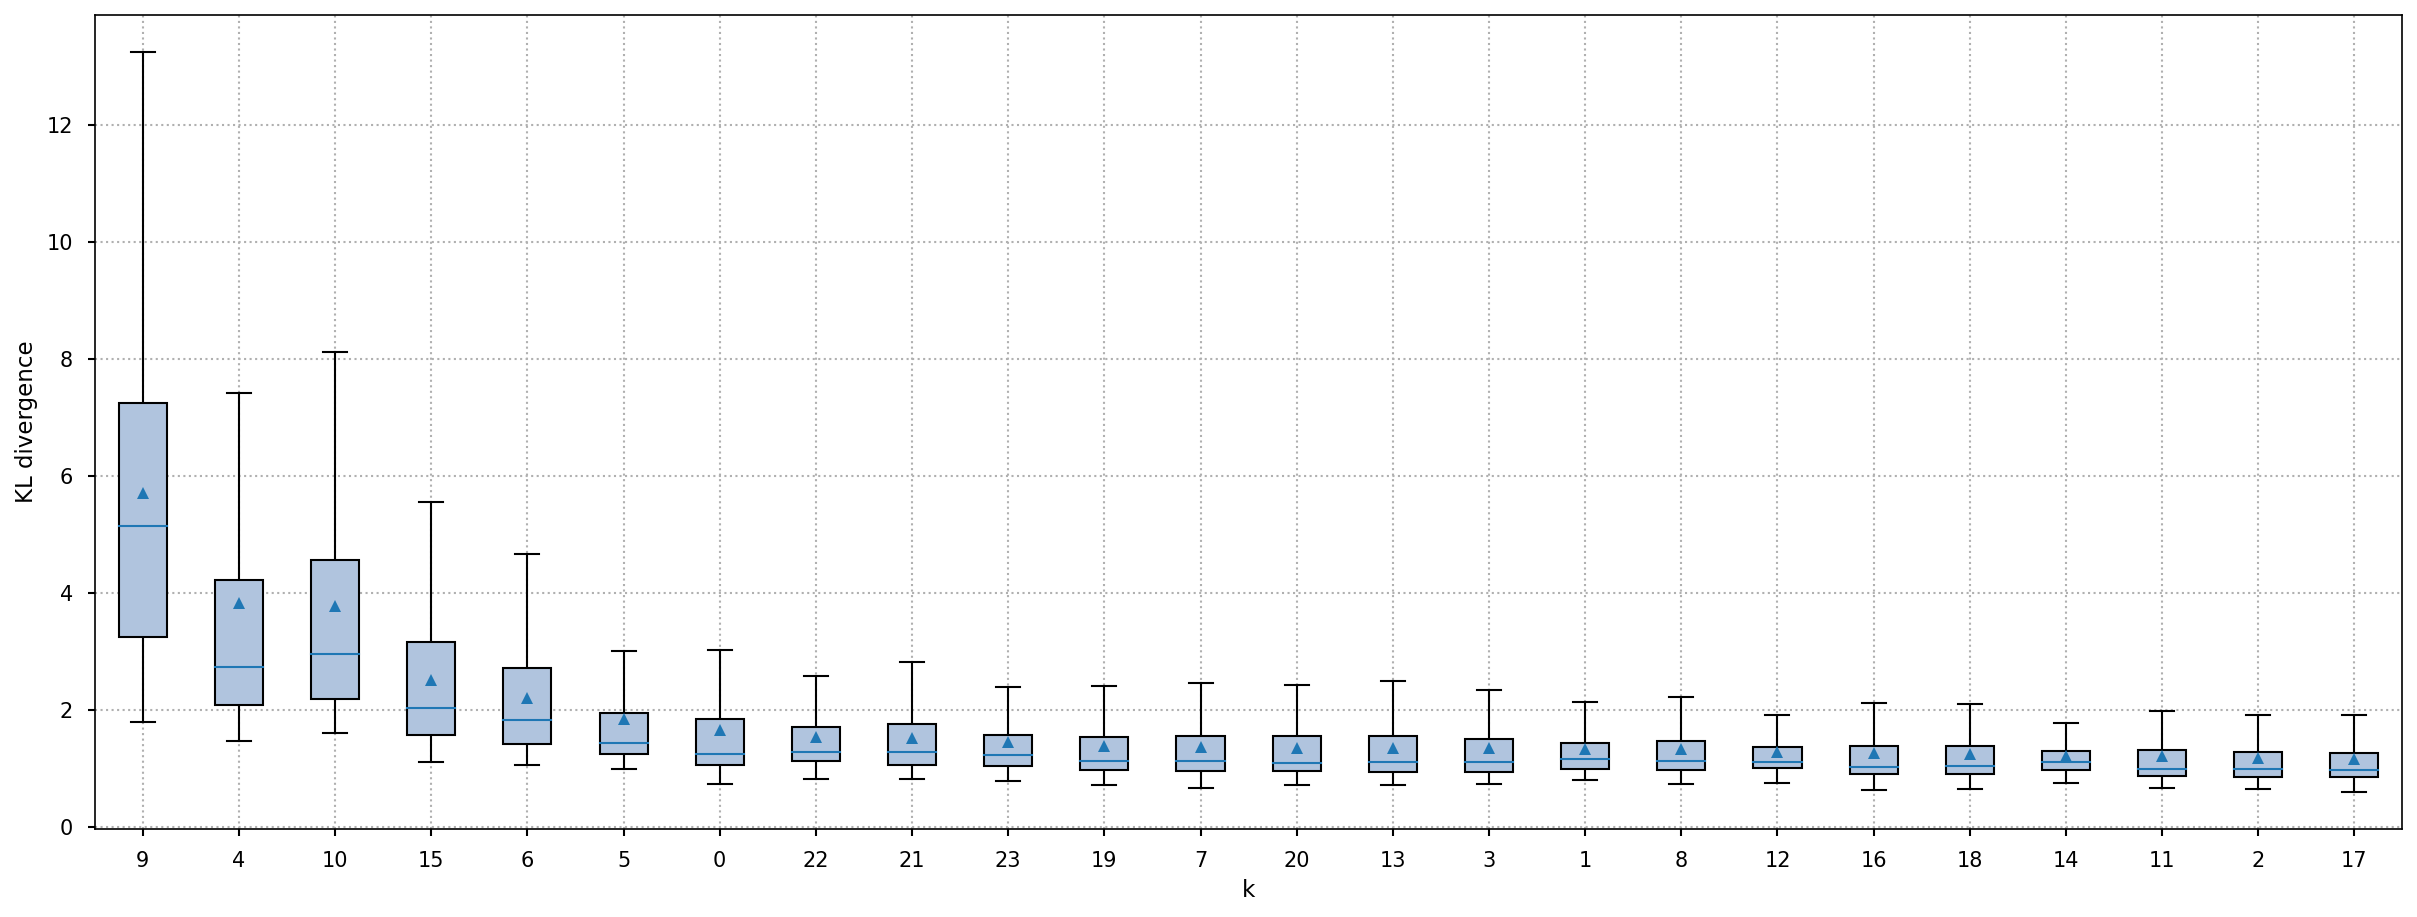

In [25]:
fig = plt.figure(0, figsize=(FIGWIDTH, 6))
fig, ax, z_order, kl_div = vplt.encoder_boxplot(encoder, val_gen, plottype='kl', name=0, verbose=VERBOSE)

The plot shows the KL divergence of the latent variables for each of the latent dimension separately. The dimensions are sorted in descending order of the KL divergence. Latent dimensions with a high KL divergence are more important for the reconstruction with the decoder. Latent dimensions that have a KL divergence close to zero are unused dimensions; i.e. they are practically not important for the reconstruction.

### Temporal behavior

Next, we analyze the temporal behavior of the latent variables. In doing so, we obtain the latent variables of the validation dataset.

In [26]:
z_mean, z_log_var = encoder.predict(val_gen, verbose=VERBOSE)
z_sample = latent_sampling.predict([z_mean, z_log_var])
z_sample = np.squeeze(z_sample)

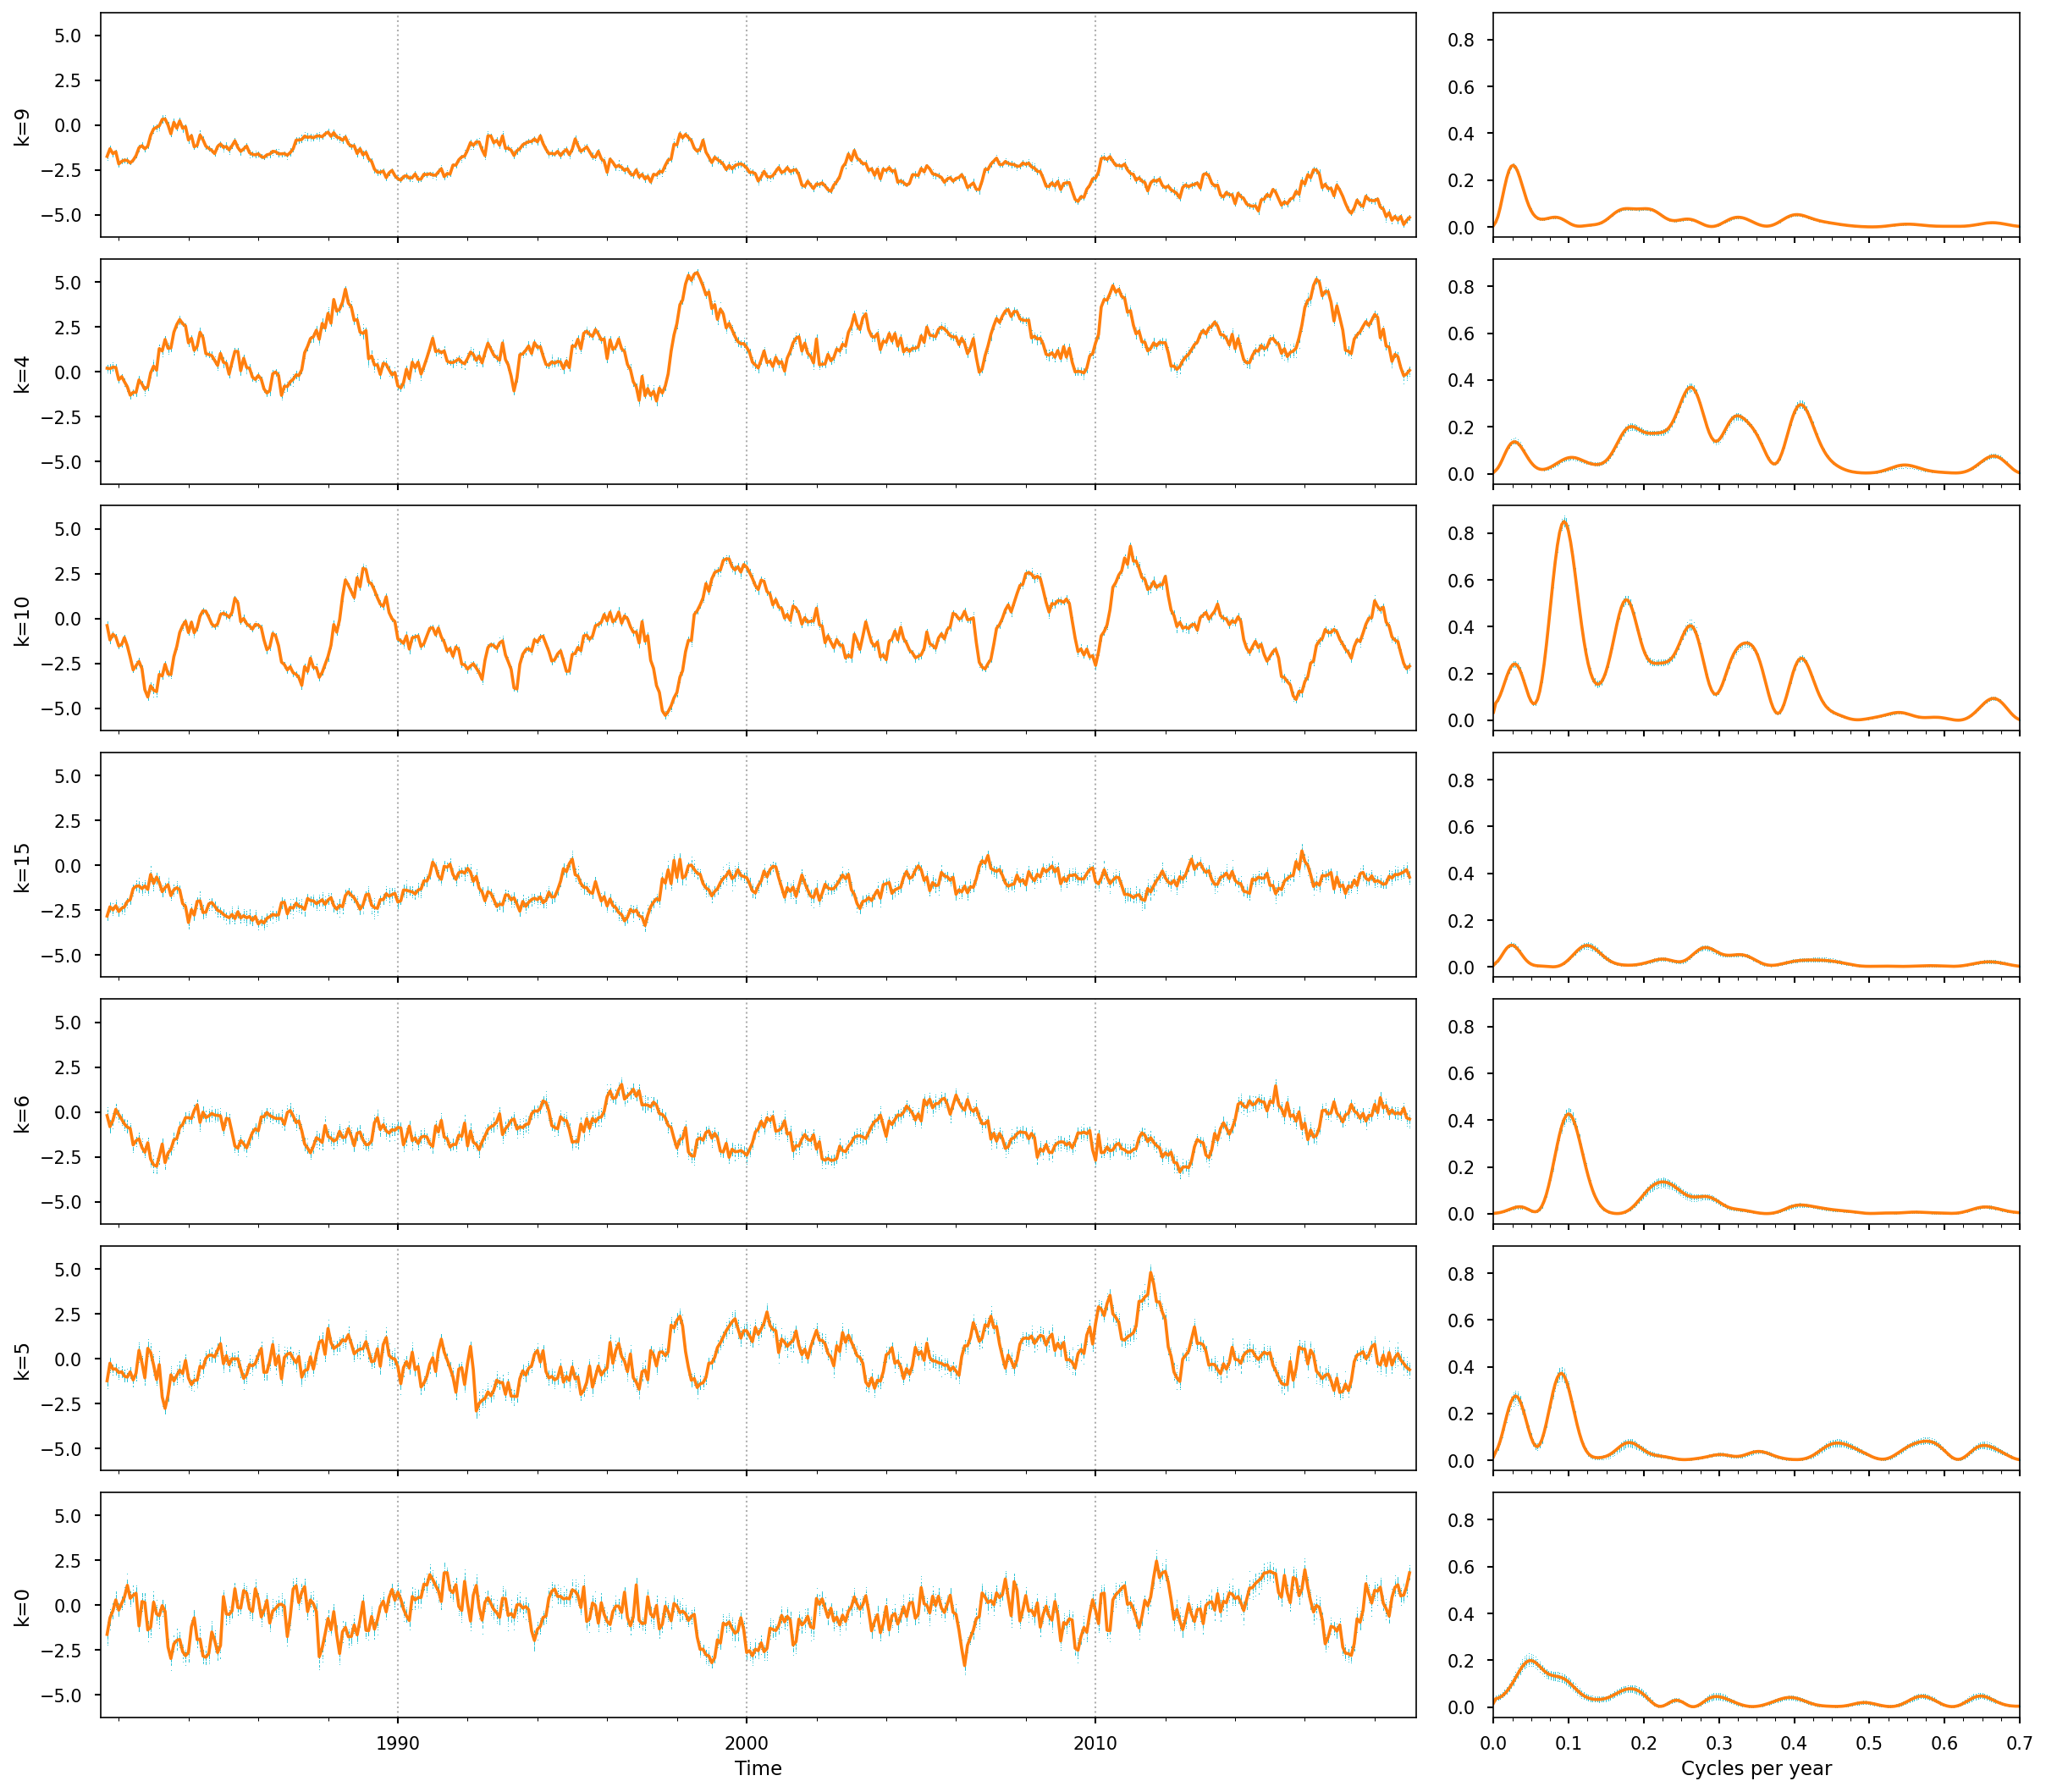

In [27]:
rows = 7
fig, axs = plt.subplots(rows,
                        2,
                        figsize=(FIGWIDTH, 2 * rows),
                        sharex='col',
                        sharey='col',
                        squeeze=False,
                        gridspec_kw={
                            'width_ratios': [2.5, 1],
                            'wspace': 0.1
                        })

r = val_gen.repeat_samples
nfft = 2**12
fs = 12

t = time[validation_split:]

for (lax, rax), k in zip(axs, z_order):
    lax.plot(t[val_gen.input_length:-val_gen.prediction_length + 1],
             z_sample[:, k].reshape(-1, r),
             '.',
             markersize=1,
             color='tab:cyan')
    lax.plot(t[val_gen.input_length:-val_gen.prediction_length + 1],
             z_sample[:, k].reshape(-1, r).mean(axis=-1),
             color='tab:orange')
    lax.set_ylabel(f'{k=}')
    lax.grid(axis='x', linestyle=':')

    f, pxx = signal.welch(z_sample[:, k].reshape(-1, r), nfft=nfft, fs=fs, nperseg=512, axis=0, scaling='spectrum')
    rax.plot(f, pxx, '.', markersize=1, color='tab:cyan')
    rax.plot(f, pxx.mean(axis=-1), color='tab:orange')

lax.margins(x=0.005)
lax.xaxis.set_major_locator(dates.YearLocator(10))
lax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
lax.xaxis.set_minor_locator(dates.YearLocator(2))
lax.set_xlabel('Time')

rax.set_xlim((0, 0.7))
rax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
rax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
_ = rax.set_xlabel('Cycles per year')

## Model output

We first obtain the model outputs for the input data to `val_gen`. The output of `decoder` is returned in `xcs` and the output of `prediction` in `ycs`.

In [28]:
xcs, ycs = model.predict(val_gen, verbose=VERBOSE)

The `decoder` and `prediction` outputs are concatenated along the lead/lag dimension and the singleton dimension for `set_size=1` is removed.

In [29]:
xcs = np.concatenate([xcs, ycs], axis=2)
xcs = np.squeeze(xcs, axis=1)

Then, the model output is aligned with the target month and split into the different variables. To reduce the later size of the netCDF files, we restrict the VAE output to specific time lags given in `export_lags`.

In [30]:
# export_lags = np.arange(-1, val_gen.prediction_length)
# export_lags = np.arange(-val_gen.input_length, val_gen.prediction_length)
export_lags = [-1, 2, 5, 8, 11]  # correspond to 0, 3, 6, 9, 12 month lead

In [31]:
# arrange runs (repeat samples) along second axis
r = val_gen.repeat_samples
xcs_runs = xcs.reshape(-1, r, *xcs.shape[1:])

level = np.arange(-val_gen.input_length, val_gen.prediction_length)
lag_idx = val_gen.input_length + np.array(export_lags)

# select lags
level = level[lag_idx]
xcs_runs = xcs_runs[:, :, lag_idx, :]

# align  with target month
xcs_runs = np.pad(xcs_runs,
                  pad_width=((val_gen.input_length, val_gen.prediction_length - 1), (0, 0), (0, 0), (0, 0)),
                  mode='constant',
                  constant_values=np.nan)

xcs_runs = np.stack([np.roll(xcs_runs[:, :, n, :], lag, axis=0) for n, lag in enumerate(level)], axis=2)

# split channels into variables
channel_splits = np.cumsum(variable_channels)
splits = np.split(xcs_runs, channel_splits, axis=-1)

xcs_variables = dict(zip(variable_names, splits))
xcs_dimensions = {variable_name: {'time': time[validation_split:], 'level': level} for variable_name in variable_names}
xcs_attributes = {
    variable_name: {
        'level': {
            'long_name': 'Time lag',
            'units': '',
            'axis': 'Z'
        }
    }
    for variable_name in variable_names
}

## Reconstruction in grid space

In the following, the model output is projected into the grid space by forming the scalar product of the model output with the EOFs. The result is exported as netCDF file.

### Load EOFs

First, we load the EOFs from the `eofs.nc` files, which can also be found in the data folders.

In [32]:
eof_files = [os.path.join(os.path.dirname(filename), 'eofs.nc') for filename in params.data2['filename']]
_eof_variables, _eof_dimensions, _eof_attributes = fileio.read_netcdf_multi(filename=eof_files,
                                                                            time_range=params.data.get('level_range'),
                                                                            dtype=params.data2.get('dtype'))

data\gpcc\prj\eofs.nc  : 1 file(s) found.
data\ersst\prj\eofs.nc : 1 file(s) found.
2/2 [==============================] - 0s 0s/file


In [33]:
eof_variables = {}
eof_dimensions = {}
eof_attributes = {}
for key, value in _eof_variables.items():
    eof_variables |= value

    eof_dimensions |= {k: _eof_dimensions[key] for k in value}
    eof_attributes |= {k: _eof_attributes[key] for k in value}

In [34]:
print('EOF variables  :', list(eof_variables))
print('Data variables :', list(xcs_variables))

EOF variables  : ['pr', 'tos']
Data variables : ['precip', 'sst']


### Load climatological mean

To obtain absolute values, we also load the corresponding climatological mean fields. The netCDF files will be looked up in the `mean_path` folder, relative to the data folders.

In [35]:
mean_path = '../mean/*.nc'
mean_files = [os.path.join(os.path.dirname(filename), mean_path) for filename in params.data2['filename']]
_mean_variables, _mean_dimensions, _mean_attributes = fileio.read_netcdf_multi(filename=mean_files,
                                                                               num2date=True,
                                                                               dtype=params.data2.get('dtype'))

data\gpcc\mean\*.nc  : 1 file(s) found.
data\ersst\mean\*.nc : 1 file(s) found.
2/2 [==============================] - 0s 9ms/file


In [36]:
mean_variables = {}
mean_dimensions = {}
mean_attributes = {}
for key, value in _mean_variables.items():
    mean_variables |= value

    mean_dimensions |= {k: _mean_dimensions[key] for k in value}
    mean_attributes |= {k: _mean_attributes[key] for k in value}

### Export to netCDF

We form the dot product of the model outputs with the EOFs and add the climatological mean. Optionally, the log transform is reverted. Different ensemble statistics are obtained from the stochastic output of the VAE. The result is written to netCDF files in the folder given in `EXPORT_DIR`.

In [37]:
os.makedirs(EXPORT_DIR, exist_ok=True)

In [38]:
prcs = {'ensmedian': 50, 'enspctl10': 10, 'enspctl90': 90}

for (data_key, value), (eof_key, eof) in zip(xcs_variables.items(), eof_variables.items()):
    print('-' * 3, data_key, '-' * (77 - len(data_key)))
    filename = '{prefix:s}' + data_key + '.{type:s}.nc'
    filename = os.path.join(EXPORT_DIR, filename)
    nc_dimensions = mean_dimensions[data_key] | dimensions[data_key] | xcs_dimensions[data_key]
    nc_attributes = mean_attributes[data_key] | attributes[data_key] | xcs_attributes[data_key]
    kwargs = dict(dimensions=nc_dimensions, attributes=nc_attributes)

    # scalar product
    nc_variable = np.tensordot(value, eof, axes=1)

    # save anomalies
    fileio.write_netcdf(filename.format(prefix='anom_', type='ensmean'),
                        variables={data_key: np.mean(nc_variable, axis=1)},
                        **kwargs)

    nc_prcs = np.percentile(nc_variable, list(prcs.values()), axis=1)
    for type, value in zip(prcs, nc_prcs):
        fileio.write_netcdf(filename.format(prefix='anom_', type=type), variables={data_key: value}, **kwargs)

    # revert to absolute values
    months = pd.to_datetime(xcs_dimensions[data_key]['time']).month
    mean_months = pd.to_datetime(mean_dimensions[data_key]['time']).month
    for month in mean_months:
        nc_variable[months == month, ...] += mean_variables[data_key][mean_months == month, ...]

    # invert log transform
    if '-log ' in eof_attributes[eof_key]['.']['history']:
        nc_variable = np.exp(nc_variable)

    # save absolute values
    fileio.write_netcdf(filename.format(prefix='', type='ensmean'),
                        variables={data_key: np.mean(nc_variable, axis=1)},
                        **kwargs)

    nc_prcs = np.percentile(nc_variable, list(prcs.values()), axis=1)
    for type, value in zip(prcs, nc_prcs):
        fileio.write_netcdf(filename.format(prefix='', type=type), variables={data_key: value}, **kwargs)

--- precip -----------------------------------------------------------------------
Write: results\2023-06-16T15.59\anom_precip.ensmean.nc
Write: results\2023-06-16T15.59\anom_precip.ensmedian.nc
Write: results\2023-06-16T15.59\anom_precip.enspctl10.nc
Write: results\2023-06-16T15.59\anom_precip.enspctl90.nc
Write: results\2023-06-16T15.59\precip.ensmean.nc
Write: results\2023-06-16T15.59\precip.ensmedian.nc
Write: results\2023-06-16T15.59\precip.enspctl10.nc
Write: results\2023-06-16T15.59\precip.enspctl90.nc
--- sst --------------------------------------------------------------------------
Write: results\2023-06-16T15.59\anom_sst.ensmean.nc
Write: results\2023-06-16T15.59\anom_sst.ensmedian.nc
Write: results\2023-06-16T15.59\anom_sst.enspctl10.nc
Write: results\2023-06-16T15.59\anom_sst.enspctl90.nc
Write: results\2023-06-16T15.59\sst.ensmean.nc
Write: results\2023-06-16T15.59\sst.ensmedian.nc
Write: results\2023-06-16T15.59\sst.enspctl10.nc
Write: results\2023-06-16T15.59\sst.enspctl

## Post processing

In the following we derive predictions of cumulative rainfall indices covering the growing seasons of the main crops. We first load the data on the growing season from the `data/crop/` folder. The data is assumed to be on the same grid as the EOFs.

In [39]:
crop_file = 'data/crop/soy_rf_ggcmi_crop_calendar_phase3_v1.01_1dgr.nc'

In [40]:
crop_variables, _, _ = fileio.read_netcdf(filename=crop_file)
print('Available data:', {k: v.shape for k, v in crop_variables.items()})

Available data: {'planting_day': (43, 46), 'maturity_day': (43, 46), 'growing_season_length': (43, 46), 'data_source_used': (43, 46)}


We load the netCDF files with the VAE output for further post-processing.

In [41]:
filename = os.path.join(EXPORT_DIR, variable_names[0] + '*.nc')
result_variables, result_dimensions, result_attributes = fileio.read_netcdf_multi(filename=filename, num2date=True)
print(*list(result_variables.keys()), sep='\n')

results\2023-06-16T15.59\precip*.nc : 4 file(s) found.
4/4 [==============================] - 1s 226ms/file
results\2023-06-16T15.59\precip.ensmean.nc
results\2023-06-16T15.59\precip.ensmedian.nc
results\2023-06-16T15.59\precip.enspctl10.nc
results\2023-06-16T15.59\precip.enspctl90.nc


In [42]:
planting_day = crop_variables['planting_day']
growing_season_length = crop_variables['growing_season_length']

We obtain the cumulative values for each of the loaded VAE outputs and write the results to netCDF files with the prefix `cum_` preprended to the filename. THe files are saved in the same folder as the VAE output files.

In [43]:
for filename, values in result_variables.items():
    # monthly values refer to end month (M = month end frequency)
    source_time = pd.to_datetime(result_dimensions[filename]['time']).snap('M')
    # new time is Jan-01 of each year (YS = year start frequency)
    target_time = source_time.snap('YS').unique()

    # iterate over variables
    out_values = dict()
    for key, value in values.items():
        out_value = np.full((len(target_time), *value.shape[1:]), fill_value=np.nan, dtype=value.dtype)

        # iterate over grid points
        pbar = ks.utils.Progbar(value.shape[-1], unit_name='Longitude')
        for lon_idx in range(value.shape[-1]):
            pbar.add(1)
            for lat_idx in range(value.shape[-2]):
                if np.all(np.isnan(value[..., lat_idx, lon_idx])):
                    continue

                # converting data to Dataframe makes datetime manipulations easier
                df = pd.DataFrame(value[..., lat_idx, lon_idx], index=source_time)

                # get total cumulative rainfall at grid point
                df = df.cumsum(axis=0)

                # interpolate on daily time scales to account for fraction of month (slower computation!)
                df = df.asfreq('D').interpolate('linear')

                # get start and end dates of crop seasons
                start_time = target_time + pd.to_timedelta(planting_day[lat_idx, lon_idx] - 1, unit='D')
                end_time = start_time + pd.to_timedelta(growing_season_length[lat_idx, lon_idx], unit='D')

                # get cumulative rainfall from difference between end and start of crop season
                start_value = df.reindex(index=start_time, method='nearest').to_numpy()
                end_value = df.reindex(index=end_time, method='nearest').to_numpy()
                out_value[..., lat_idx, lon_idx] = end_value - start_value

        out_values[key] = out_value

    out_filename = os.path.join(os.path.dirname(filename), 'cum_' + os.path.basename(filename))
    fileio.write_netcdf(out_filename,
                        variables=out_values,
                        dimensions=result_dimensions[filename] | {'time': target_time},
                        attributes=result_attributes[filename])

46/46 [==============================] - 15s 332ms/Longitude
Write: results\2023-06-16T15.59\cum_precip.ensmean.nc
46/46 [==============================] - 17s 386ms/Longitude
Write: results\2023-06-16T15.59\cum_precip.ensmedian.nc
46/46 [==============================] - 15s 327ms/Longitude
Write: results\2023-06-16T15.59\cum_precip.enspctl10.nc
46/46 [==============================] - 15s 326ms/Longitude
Write: results\2023-06-16T15.59\cum_precip.enspctl90.nc


### Remark on country averages

To extract country averages from the gridded cumulative rainfall data, we can use the CDO operators `fldmean` and `maskregion`. For example, we can use the following command

```shell
cdo fldmean -maskregion,dcw:TZ infile.nc outfile.nc
```
to extract the country average for Tanzania. To extract the country average for another country, we can replace `TZ` with the corresponding country code. For more details, see the [CDO documentation](https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf) and the list of [country codes](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2).

To use country codes together with the `maskregion` operator, we need to install the `gmt-dcw` package, which is available in the Ubuntu repositories. To install the package, run `sudo apt install gmt-dcw` and set the environment variable `DCW_DIR` to the path of the `dcw-gmt` folder, e.g. `export DIR_DCW=/usr/share/gmt-dcw/`.

## Appendix

### Input example

Time: 1997-08-01 00:00:00


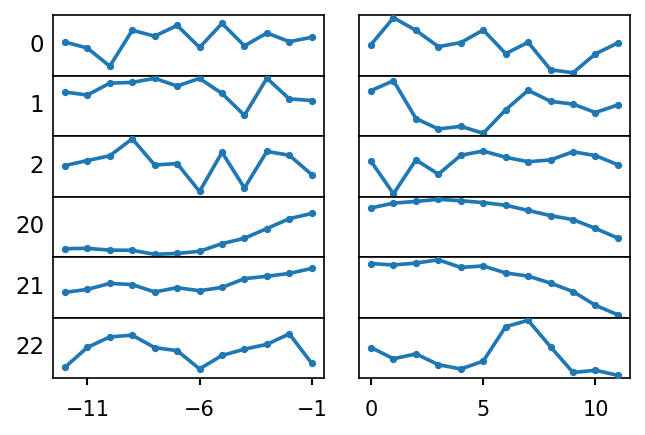

In [44]:
EXPORT = False
show_prediction = False
rows = 6
fig, axs = plt.subplots(rows, 2, figsize=(5.5 * 0.8, rows * 0.5), sharex='col', sharey='row', gridspec_kw={'hspace': 0})

batch_nr = 19
sample_nr = 1
inputs, targets = val_gen[batch_nr]
xc_batch, yc_batch = model.predict(inputs)
r = val_gen.repeat_samples
s = sample_nr * r

channels = [0, 1, 2, 20, 21, 22]

idx = val_gen.get_index(batch_nr)[:, 1] + validation_split
print('Time:', time[idx][s])
for n, (ax, x, xc) in enumerate(
        zip(axs[:, 0], targets['decoder'][s, 0, ...][..., channels].T, xc_batch[s:s + r, 0, ...][..., channels].T)):
    ax.plot(range(-val_gen.input_length, 0), x, '.-', color='tab:blue', zorder=3)
    if show_prediction:
        ax.plot(range(-val_gen.input_length, 0), xc, '.-', color='tab:orange', zorder=2)

    ax.set_ylabel(channels[n], rotation=0, ha='right', va='center')

    ax.yaxis.set_major_locator(ticker.NullLocator())

ax.xaxis.set_major_locator(ticker.FixedLocator(range(-16, 0, 5)))

for n, (ax, y, yc) in enumerate(
        zip(axs[:, 1], targets['prediction'][s, 0, ...][..., channels].T, yc_batch[s:s + r, 0, ...][..., channels].T)):
    ax.plot(y, '.-', color='tab:blue', zorder=3)
    if show_prediction:
        ax.plot(yc, '.-', color='tab:orange', zorder=2)

    ax.yaxis.set_major_locator(ticker.NullLocator())

fig.tight_layout()
if EXPORT:
    plt.rcParams['svg.fonttype'] = 'none'
    if show_prediction:
        fig.savefig('model_output.svg')
    else:
        fig.savefig('model_input.svg')